In [45]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [47]:
%matplotlib inline

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

import pandas as pd
import numpy as np
from IPython.display import HTML, display
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from itertools import product, combinations

%config InlineBackend.figure_format = 'svg'

## Sensitivity Plots

In [48]:
%autoreload

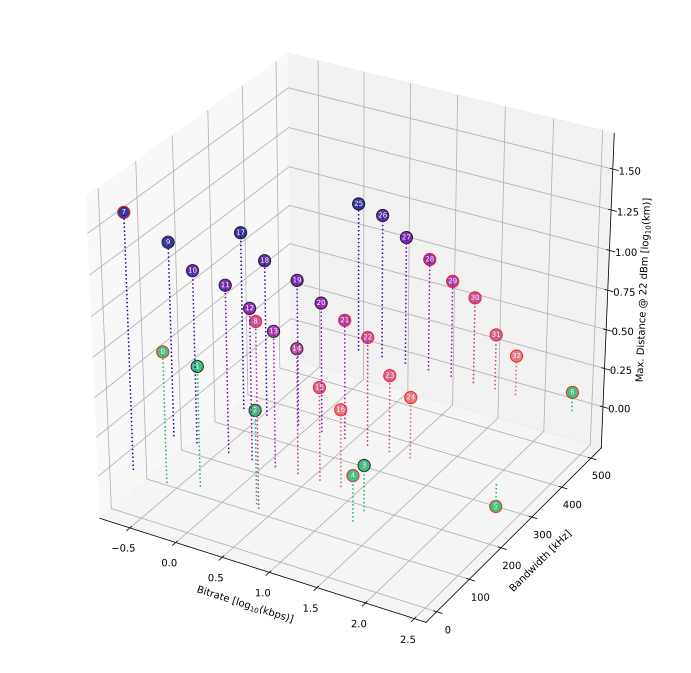

,bandwidth,bitrate,fda,modem,sensitivity,sf,distance
0,4000,600,800,RadioModem.FSK,-125,nan,6642.48
1,20000,1200,5000,RadioModem.FSK,-123,nan,5697.22
2,20000,4800,5000,RadioModem.FSK,-118,nan,3881.47
3,83000,38400,40000,RadioModem.FSK,-109,nan,1945.34
4,50000,38400,20000,RadioModem.FSK,-109,nan,1945.34
5,250000,250000,62500,RadioModem.FSK,-96,nan,717.238
6,500000,250000,125000,RadioModem.FSK,-104,nan,1325.35
7,10400,244.141,nan,RadioModem.LORA,-148,12,38814.7
8,10400,5468.75,nan,RadioModem.LORA,-135,7,14310.8
9,125000,244.141,nan,RadioModem.LORA,-137,12,16685.1


In [49]:
from flora_tools.radio_configuration import RadioConfiguration
from flora_tools.radio_math import RadioMath, SENSITIVITIES

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def is_pareto_optimal(item):
    competitors = df[(df.bitrate >= item.bitrate) & (df.bandwidth <= item.bandwidth) & (df.distance >= item.distance)]
    if len(competitors) > 1:
        return (0.0,0.0,0.0)
    else:
        return (1.0,0.0,0.0)
    
def get_color(item):
    if not np.isnan(item.sf):
        return RadioConfiguration(int(12 - item.sf)).color
    else:
        return (0.1,0.7,0.4)

df = pd.DataFrame(SENSITIVITIES)

df.loc[:,'distance'] = df.apply(RadioMath.get_theoretical_max_distance, axis=1)
df.loc[:,'bitrate'] = df.apply(RadioMath.get_bitrate, axis=1)

colors = df.apply(get_color, axis=1)
edgecolors = df.apply(is_pareto_optimal, axis=1)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')

for index, row in df.iterrows():
    ax.plot([np.log10(row.bitrate / 1000), np.log10(row.bitrate / 1000)], [row.bandwidth / 1000, row.bandwidth / 1000], [0, np.log10(row.distance / 1000)], ':', c=colors[index])

ax.scatter(np.log10(df.bitrate / 1000), df.bandwidth / 1000, np.log10(df.distance / 1000), c=colors, edgecolors=edgecolors, s=150, alpha=0.8)

for index, row in df.iterrows():
    ax.text(np.log10(row.bitrate / 1000), row.bandwidth / 1000, np.log10(row.distance / 1000), str(index), None, color='w', fontsize=7, horizontalalignment="center", verticalalignment="center")


ax = plt.gca()
plt.xlabel("Bitrate [$\log_{10}$(kbps)]")
plt.ylabel("Bandwidth [kHz]")
ax.set_zlabel("Max. Distance @ 22 dBm [$\log_{10}$(km)]")

plt.show()

df.style
    
    

# Energy Plots

In [50]:
%autoreload

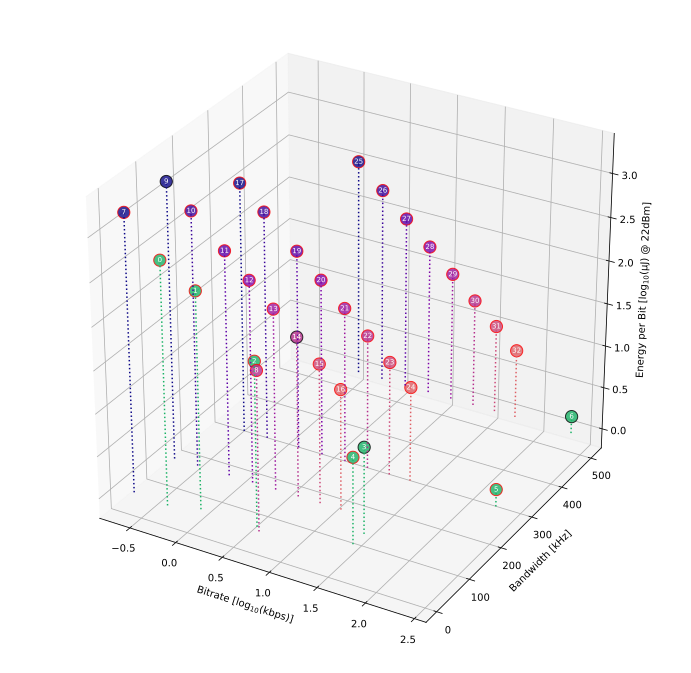

,bandwidth,bitrate,fda,modem,sensitivity,sf,energy
0,4000,600,800,RadioModem.FSK,-125,nan,0.662588
1,20000,1200,5000,RadioModem.FSK,-123,nan,0.331294
2,20000,4800,5000,RadioModem.FSK,-118,nan,0.0828235
3,83000,38400,40000,RadioModem.FSK,-109,nan,0.0103529
4,50000,38400,20000,RadioModem.FSK,-109,nan,0.0103529
5,250000,250000,62500,RadioModem.FSK,-96,nan,0.00159021
6,500000,250000,125000,RadioModem.FSK,-104,nan,0.00159021
7,10400,244.141,nan,RadioModem.LORA,-148,12,1.63971
8,10400,5468.75,nan,RadioModem.LORA,-135,7,0.0731063
9,125000,244.141,nan,RadioModem.LORA,-137,12,1.63971


In [51]:
from flora_tools.radio_configuration import RadioConfiguration
from flora_tools.radio_math import RadioMath, SENSITIVITIES

from mpl_toolkits.mplot3d import Axes3D

def is_pareto_optimal(item):
    competitors = df[(df.bitrate >= item.bitrate) & (df.bandwidth <= item.bandwidth) & (df.energy >= item.energy)]
    if len(competitors) > 1:
        return (0.0,0.0,0.0)
    else:
        return (1.0,0.0,0.0)
    
def get_color(item):
    if not np.isnan(item.sf):
        return RadioConfiguration(int(12 - item.sf)).color
    else:
        return (0.1,0.7,0.4)

df = pd.DataFrame(SENSITIVITIES)

df.loc[:,'energy'] = df.apply(RadioMath.get_energy_per_bit, axis=1)
df.loc[:,'bitrate'] = df.apply(RadioMath.get_bitrate, axis=1)

colors = df.apply(get_color, axis=1)
edgecolors = df.apply(is_pareto_optimal, axis=1)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')

for index, row in df.iterrows():
    ax.plot([np.log10(row.bitrate / 1000), np.log10(row.bitrate / 1000)], [row.bandwidth / 1000, row.bandwidth / 1000], [0, np.log10(row.energy * 1000)], ':', c=colors[index])
    
ax.scatter(np.log10(df.bitrate / 1000), df.bandwidth / 1000, np.log10(df.energy * 1000), c=colors, edgecolors=edgecolors, s=150, alpha=0.8)

for index, row in df.iterrows():
    ax.text(np.log10(row.bitrate / 1000), row.bandwidth / 1000, np.log10(row.energy * 1000), str(index), None, color='w', fontsize=7, horizontalalignment="center", verticalalignment="center")

ax = plt.gca()
plt.xlabel("Bitrate [$\log_{10}$(kbps)]")
plt.ylabel("Bandwidth [kHz]")
ax.set_zlabel("Energy per Bit [$\log_{10}$(µJ) @ 22dBm]")

plt.show()

df.style
    
    

# Power Consumption and Efficiency



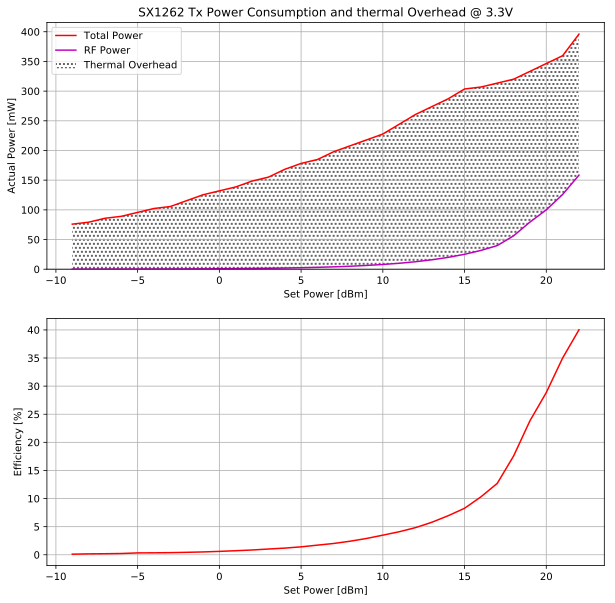

In [52]:
from flora_tools.radio_configuration import TX_CURRENT_LOOKUP_TABLE, TX_ACTUAL_POWER_LOOKUP_TABLE

import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

VOLTAGE = 3.3


def power_consumption(power):  # mW
    current = np.interp(power, TX_CURRENT_LOOKUP_TABLE[0], TX_CURRENT_LOOKUP_TABLE[1])
    return VOLTAGE * current
    
def actual_power(power):  # dBm
    return np.interp(power, TX_ACTUAL_POWER_LOOKUP_TABLE[0], TX_ACTUAL_POWER_LOOKUP_TABLE[1])

POWERS = np.array(range(-9, 23))

plt.figure(figsize=[10,10])

plt.subplot(2, 1, 1)

plt.plot(POWERS, power_consumption(POWERS), c='r', label='Total Power')
plt.plot(POWERS, np.power(10, actual_power(POWERS)/10), c='m', label='RF Power')
 
ax = plt.gca()
ax.grid(True)
    
plt.ylim(ymin=0)
    
ax.fill_between(POWERS, power_consumption(POWERS), np.power(10, actual_power(POWERS)/10), hatch='...', facecolor="none", label='Thermal Overhead', linewidth=0)

plt.legend()
    
plt.title("SX1262 Tx Power Consumption and thermal Overhead @ 3.3V")
plt.xlabel("Set Power [dBm]")
plt.ylabel("Actual Power [mW]")
    


plt.subplot(2, 1, 2)

plt.plot(POWERS, 100 * np.power(10, actual_power(POWERS)/10) / power_consumption(POWERS), c='r', label='Efficiency')
plt.xlabel("Set Power [dBm]")
plt.ylabel("Efficiency [%]")
ax = plt.gca()
ax.grid(True)


plt.show()

## Hop-Example

Two nodes require 22 dBm to communicate with each other. A new intermediate node appears perfectly in between the nodes, relaying the nodes' messages to each other. The required Tx power regarding cubic path loss gets to be


In [69]:
new_power_level = 22 + np.log10(1/(np.power(3,2))) * 10
new_power_level

12.457574905606752

Keep in mind that we now have to send each message twice.
This results in the original scenario with a over total power (mW) of

In [70]:
old_power = power_consumption(22)
old_power

396.0

In [71]:
new_power = power_consumption(new_power_level) * 2
new_power

533.4799775080182

We need more power even under the pessimistic assumption of cubic decay for multi-hopping! We need twice the time! We have more radio-MCU communication. Our only benefit is having used less space (Space Division Multiple Access, SDMA). Now we look at a square decay:

In [63]:
new_power_level = 22 + np.log10(1/(np.power(2,2))) * 10
new_power_level

15.979400086720375

In [64]:
old_power = power_consumption(22)
old_power

396.0

In [65]:
new_power = power_consumption(new_power_level) * 2
new_power

613.6640405723545